# Assignment 2  - Part B


#### Roll Number:2022-10-0001

### Task Explanation

In this task, we will perform feature extraction and fine-tuning on a previously trained over a large dataset model. This is a very useful domain of Deep Learning known as Transfer Learning. We don't always have the luxury of time and computational power to adequately train a large model over our dataset. So, we use models which have been trained on large datasets (usually ImageNet) and then fine-tune them on our dataset. The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

Here, we will fine-tune a previously trained model on imagenet to learn and classify Marvel Superheroes.

### Dataset



use this [link](https://drive.google.com/drive/folders/1O3crt73u20vAOK11FU59uvKai9DCggOa?usp=sharing) to add the dataset folder shortcut to your drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip '/content/gdrive/MyDrive/Deep Learning/A2/marvel.zip' -d '/content/gdrive/MyDrive/Deep Learning/A2/marvel_images'

### Task 1


the Marvel Superheroes dataset consists of 8 classes, you have to add another class for "Thor" 

you are welcome to scrape images from any online source, make another folder for Thor inside train and val directories.

make sure there are different images in the validation and training datasets.

In [2]:
# find the number of images to scrape

import glob
img_paths = []
files = glob.glob("/content/gdrive/MyDrive/Deep Learning/A2/marvel_images/marvel/**/hulk/*", recursive = False)
for file in files:
  img_paths.append(file)
print("Number of thor images to scrape is approximately {}".format(len(img_paths)))

Number of thor images to scrape is approximately 377


Used https://towardsdatascience.com/image-scraping-with-python-a96feda8af2d to scrape 300 thor images

### Task 2

In this task we will be downloding pre-trained models and further train them through feature extraction and finetuning on our Marvel dataset.

Finally, we will compare these models with a third model trained from scratch.

### Models


You can use anyone of the following models for this task. See the [documentation](https://pytorch.org/vision/stable/models.html) for more details.
- VGG
- ResNet
- MobileNet
- EfficientNet

### Tutuorial Example

You are recommended to follow this [tutorial](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#create-the-optimizer) for this task. All the hints and information required are available here and this task can be easily completed by following it. In this tutorial, they use MobileNet but as mentioned above you are free to use any of the abovementioned models.

In [3]:
# make any other necessary imports here
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

import cv2
import glob
import re
from google.colab.patches import cv2_imshow
from torch.utils.data import DataLoader

PyTorch Version:  1.10.0+cu111
Torchvision Version:  0.11.1+cu111


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Define hyperparameters

In [32]:
# define hyperparameters
data_dir = "/content/marvel_dataset/marvel"

# Number of classes in the dataset
num_classes = 9

# Batch size for training (change depending on how much memory you have)
batch_size = 64

# Number of epochs to train for
num_epochs = 30

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params i.e  perform feature extraction
feature_extract = True

input_shape = (224,224)

### Data Load

Load the data and initialize dataloaders here.


##### Extract the labels

In [6]:

# Labels 
my_labels={}
files = glob.glob("/content/gdrive/MyDrive/Deep Learning/A2/marvel_images/marvel/train/*", recursive = False)
for i, file in enumerate(files):
  label = re.split("/", file)[9]
  my_labels[label] = i
print("The labels are:", my_labels)


The labels are: {'thanos': 0, 'black widow': 1, 'captain america': 2, 'doctor strange': 3, 'hulk': 4, 'ironman': 5, 'loki': 6, 'spider-man': 7, 'thor': 8}


##### Find the paths for training and validation data

In [7]:
training_paths = []
files = glob.glob("/content/gdrive/MyDrive/Deep Learning/A2/marvel_images/marvel/train/**/*", recursive = False)
for file in files:
  training_paths.append(file)
print("Length of training paths {}".format(len(training_paths)))

Length of training paths 2789


In [8]:
valid_paths = []
files = glob.glob("/content/gdrive/MyDrive/Deep Learning/A2/marvel_images/marvel/valid/**/*", recursive = False)
for file in files:
  valid_paths.append(file)
print("Length of training paths {}".format(len(valid_paths)))

Length of training paths 520


##### Data Generator Function

In [9]:
def preprocessing_norm(images):
    images = images / 255
    return images

# Data generator function 
def data_generator(img_path_list):
  
  return_list = []
  num_samples = len(img_path_list)
  
  for img_path in img_path_list:
 
    im_cv = cv2.imread(img_path)
    im_cv = im_cv.astype(np.float32)
    im_cv = cv2.cvtColor(im_cv, cv2.COLOR_BGR2RGB) # convert to RGB
    im_cv = cv2.resize(im_cv, input_shape)
    im_cv = np.transpose(preprocessing_norm(im_cv))
    
    label = re.split("/", img_path)[9]
    label = my_labels[label] # convert to numeric label

    return_list.append((im_cv, label))
    
  return return_list

##### Create training and validation loaders

In [10]:
# create a training loader
training_loader = DataLoader(data_generator(training_paths), batch_size=batch_size, shuffle=True)

# create a validation loader
validation_loader = DataLoader(data_generator(valid_paths), batch_size=batch_size, shuffle=True)

# create dictionary
dataloaders_dict = {'train': training_loader, 'val': validation_loader}

### Helper Functions

Define the train_model function here.

In [11]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

next, define the set_parameter_requires_grad() function.

When performing feature extracting, we do not update the model's weights from prior training. We only update the new top layer added.

When performing finetuning, we update all the weights for all the layers.

In [33]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

Define the initialize_model function here, you do not need to include all the categories , simply include the one or more relevant to the model you are using.

In [34]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model("resnet", num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Creating Optimizer

We have to send the model to our device, which could be the GPU or CPU.


In [35]:
# Send the model to GPU
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#Code here
model_ft = model_ft.to(device)


We also have to define an optimizer which updates only relevant parameters.
For instance, when performing **feature extraction**, recall that only top new layer(s) are to be updated. So you'll only see `fc.weight` and `fc.bias` as layers to be updated.

When performing **finetuning**, all the layers will be updated so you'll see a long list of layers printed out if `feature_extract=None`

 this piece of code from the referenced tutorial will help make sure that only relevant layers have `.requires_grad=True` 

In [36]:

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    print('feature extraction')
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    print('finetuning ')
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)



Params to learn:
feature extraction
	 fc.weight
	 fc.bias


In [37]:
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
# Observe that all parameters are being optimized
#Code here

### Training the model


Now we use the function defined above tp train the model.

In [38]:
# Setup the loss fxn
#Code here
criterion = nn.CrossEntropyLoss()

# Train and evaluate
#Code here
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=False)


Epoch 0/29
----------
train Loss: 1.9344 Acc: 0.3105
val Loss: 1.5345 Acc: 0.5192

Epoch 1/29
----------
train Loss: 1.4976 Acc: 0.5048
val Loss: 1.3806 Acc: 0.5635

Epoch 2/29
----------
train Loss: 1.3694 Acc: 0.5507
val Loss: 1.3146 Acc: 0.5712

Epoch 3/29
----------
train Loss: 1.2779 Acc: 0.5780
val Loss: 1.2756 Acc: 0.5788

Epoch 4/29
----------
train Loss: 1.2310 Acc: 0.5859
val Loss: 1.2556 Acc: 0.5750

Epoch 5/29
----------
train Loss: 1.2113 Acc: 0.5973
val Loss: 1.2576 Acc: 0.5904

Epoch 6/29
----------
train Loss: 1.1635 Acc: 0.6210
val Loss: 1.2532 Acc: 0.5731

Epoch 7/29
----------
train Loss: 1.1615 Acc: 0.6210
val Loss: 1.2644 Acc: 0.5981

Epoch 8/29
----------
train Loss: 1.1140 Acc: 0.6307
val Loss: 1.2616 Acc: 0.5923

Epoch 9/29
----------
train Loss: 1.1205 Acc: 0.6285
val Loss: 1.2351 Acc: 0.5981

Epoch 10/29
----------
train Loss: 1.0885 Acc: 0.6361
val Loss: 1.2449 Acc: 0.5923

Epoch 11/29
----------
train Loss: 1.0805 Acc: 0.6346
val Loss: 1.2314 Acc: 0.5923

Ep

### Finetuning

We will now perform finetuning, let's initialize a new model

In [15]:
#Code here
# Initialize the model for this run
feature_extract=False
model_ft2, input_size = initialize_model("resnet", num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft2)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
# Send the model to GPU
#Code here
model_ft2 = model_ft2.to(device)

Now set `feature_extraction=False`, and run this code again, you should see a long list of layers printed.

Recall the difference between finetuning and feature extraction


tip: set the learning rate much lower for finetuning.

In [17]:
feature_extract=False

In [21]:


params_to_update = model_ft2.parameters()
print("Params to learn:")
if feature_extract:
    print('feature extraction')
    params_to_update = []
    for name,param in model_ft2.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    print('finetuning ')
    for name,param in model_ft2.named_parameters():
        if param.requires_grad == True:
            print("\t",name)



Params to learn:
finetuning 
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight


now repeat the above process to train the model.

In [22]:
#Code here
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
model_ft2, hist2 = train_model(model_ft2, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=False)

Epoch 0/29
----------
train Loss: 1.6858 Acc: 0.4059
val Loss: 1.1907 Acc: 0.5904

Epoch 1/29
----------
train Loss: 0.9511 Acc: 0.6942
val Loss: 1.0875 Acc: 0.6481

Epoch 2/29
----------
train Loss: 0.5847 Acc: 0.8211
val Loss: 1.1626 Acc: 0.6442

Epoch 3/29
----------
train Loss: 0.3527 Acc: 0.9043
val Loss: 1.2030 Acc: 0.6692

Epoch 4/29
----------
train Loss: 0.2202 Acc: 0.9484
val Loss: 1.2220 Acc: 0.6788

Epoch 5/29
----------
train Loss: 0.1617 Acc: 0.9624
val Loss: 1.2658 Acc: 0.6673

Epoch 6/29
----------
train Loss: 0.1264 Acc: 0.9688
val Loss: 1.2798 Acc: 0.6885

Epoch 7/29
----------
train Loss: 0.1056 Acc: 0.9702
val Loss: 1.3024 Acc: 0.6827

Epoch 8/29
----------
train Loss: 0.0974 Acc: 0.9720
val Loss: 1.3047 Acc: 0.6846

Epoch 9/29
----------
train Loss: 0.0878 Acc: 0.9745
val Loss: 1.3295 Acc: 0.6923

Epoch 10/29
----------
train Loss: 0.0796 Acc: 0.9738
val Loss: 1.3499 Acc: 0.6731

Epoch 11/29
----------
train Loss: 0.0773 Acc: 0.9760
val Loss: 1.3104 Acc: 0.6885

Ep

### Training from scratch

Train a third model from scratch, similar as above.


We won't have to worry about updating layers, simply set `use_pretrained=False` in initialize_model function, send model to device, define optimizer and loss and run training.

In [24]:
#Code here
# Initialize the model for this run
feature_extract=False
model_ft3, input_size = initialize_model("resnet", num_classes, feature_extract, use_pretrained=False)

# Print the model we just instantiated
print(model_ft3)



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
params_to_update = model_ft3.parameters()
print("Params to learn:")
if feature_extract:
    print('feature extraction')
    params_to_update = []
    for name,param in model_ft2.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    print('finetuning ')
    for name,param in model_ft2.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
finetuning 
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight


In [26]:
# Send the model to GPU
model_ft3 = model_ft3.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
model_ft3, hist3 = train_model(model_ft3, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=False)

Epoch 0/29
----------
train Loss: 2.1673 Acc: 0.1599
val Loss: 2.1398 Acc: 0.2058

Epoch 1/29
----------
train Loss: 2.0509 Acc: 0.2363
val Loss: 2.1651 Acc: 0.1923

Epoch 2/29
----------
train Loss: 1.9513 Acc: 0.2729
val Loss: 1.9522 Acc: 0.2846

Epoch 3/29
----------
train Loss: 1.8851 Acc: 0.3076
val Loss: 1.9981 Acc: 0.2846

Epoch 4/29
----------
train Loss: 1.7950 Acc: 0.3564
val Loss: 1.9451 Acc: 0.3250

Epoch 5/29
----------
train Loss: 1.7369 Acc: 0.3733
val Loss: 1.8493 Acc: 0.3462

Epoch 6/29
----------
train Loss: 1.6773 Acc: 0.4087
val Loss: 1.9162 Acc: 0.3154

Epoch 7/29
----------
train Loss: 1.5866 Acc: 0.4493
val Loss: 1.7684 Acc: 0.3769

Epoch 8/29
----------
train Loss: 1.4972 Acc: 0.4808
val Loss: 2.1461 Acc: 0.3115

Epoch 9/29
----------
train Loss: 1.4209 Acc: 0.5041
val Loss: 1.8385 Acc: 0.3558

Epoch 10/29
----------
train Loss: 1.2846 Acc: 0.5579
val Loss: 2.1462 Acc: 0.3269

Epoch 11/29
----------
train Loss: 1.1404 Acc: 0.6260
val Loss: 2.0715 Acc: 0.3692

Ep

### Comparing models

using data from all three models you have trained, plot a graph comparing validation Accuracy vs. Number of Epochs for your models for performance comparison.

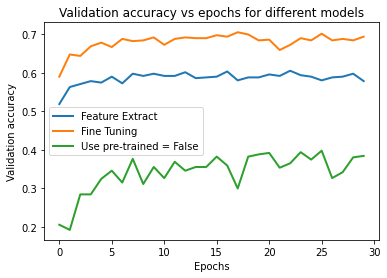

In [39]:
# Loss Plot
import matplotlib.pyplot as plt

# plot
fig, ax = plt.subplots()

ax.plot(range(num_epochs), [x.cpu() for x in hist], linewidth=2.0, label="Feature Extract")
ax.plot(range(num_epochs), [x.cpu() for x in hist2], linewidth=2.0, label="Fine Tuning")
ax.plot(range(num_epochs), [x.cpu() for x in hist3], linewidth=2.0, label="Use pre-trained = False")
ax.set_xlabel('Epochs')
ax.set_ylabel('Validation accuracy')
ax.set_title('Validation accuracy vs epochs for different models')

plt.legend()
plt.show()

Question: Which of the three trained models performed best in terms of validation accuracy?
Explain why.

Answer: Fine tuning performed the best in terms of validation accuracy. The pretrained model parameters were being updated based on the new marvel classification dataset. This made the model more specific to this dataset thereby improving the validation accuracy. The model that performed worst was the one where no pre-trained weights were imported. Essentially, in this case, no transfer learning was used.